In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as sps
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.datasets import load_iris
%matplotlib inline

left = 0
right = 9

In [2]:
data = load_iris()

#раскидываем измерения по типам ирисам
iris=[[], [], []]
for i in range(len(data.target)):
    iris[data.target[i]].append(data.data[i])
iris = np.array(iris)

Занумеруем координаты векторов (измерений ириса) числами 0, 1, 2, 3. Для пар координат (0, 1), (1, 3) и (2, 3) вычислим плотность каждой компоненты смеси (три плотности для каждой пары координат), оценив параметры распределений по проекциям трех выборок (каждая выборка соответствует одной компоненте смеси) на соответствующие плоскости. Нарисуем графики (линии уровня) этих плотностей (3 × 3 = 9 штук), на которые нанесем также соответствующие проекции точек выборки.

In [3]:
def build_density(coors, iris_type, num_plot):
    #извлекаем нужные координаты
    pairs = np.array([iris[iris_type].transpose()[coors[0]], iris[iris_type].transpose()[coors[1]]])

    #ищем (оцениваем) параметры разложения
    a_est = [pairs[0].mean(), pairs[1].mean()]
    sigma_est = np.zeros(4).reshape(2, 2)
    for i in range(2):
        for j in range(2):
            sigma_est[i][j] = np.mean(pairs[i] * pairs[j]) - np.mean(pairs[i]) * np.mean(pairs[j])

    #считаем плотность
    grid = np.mgrid[min(pairs[0])-0.5:max(pairs[0])+0.5:((max(pairs[0]) - min(pairs[0]) + 1)/100), 
                    min(pairs[1])-0.5:max(pairs[1])+0.5:((max(pairs[1]) - min(pairs[1]) + 1)/100)]
    size = grid[0].shape[0]
    density = np.zeros(size**2).reshape(size, size)
    for i in range(size):
        for j in range (size):
            density[i][j] = sps.multivariate_normal.pdf((grid[0, i, j], grid[1, i, j]), mean=a_est, cov=sigma_est)
            
    #строим график
    plt.subplot(3,3,num_plot+1)
    plt.contour(grid[0], grid[1], density) 
    plt.scatter(pairs[0], pairs[1], color='blue')
    plt.title('type = ' + str(iris_type) + ', coors = (' + str(coors[0]) + ',' + str(coors[1]) + ')')

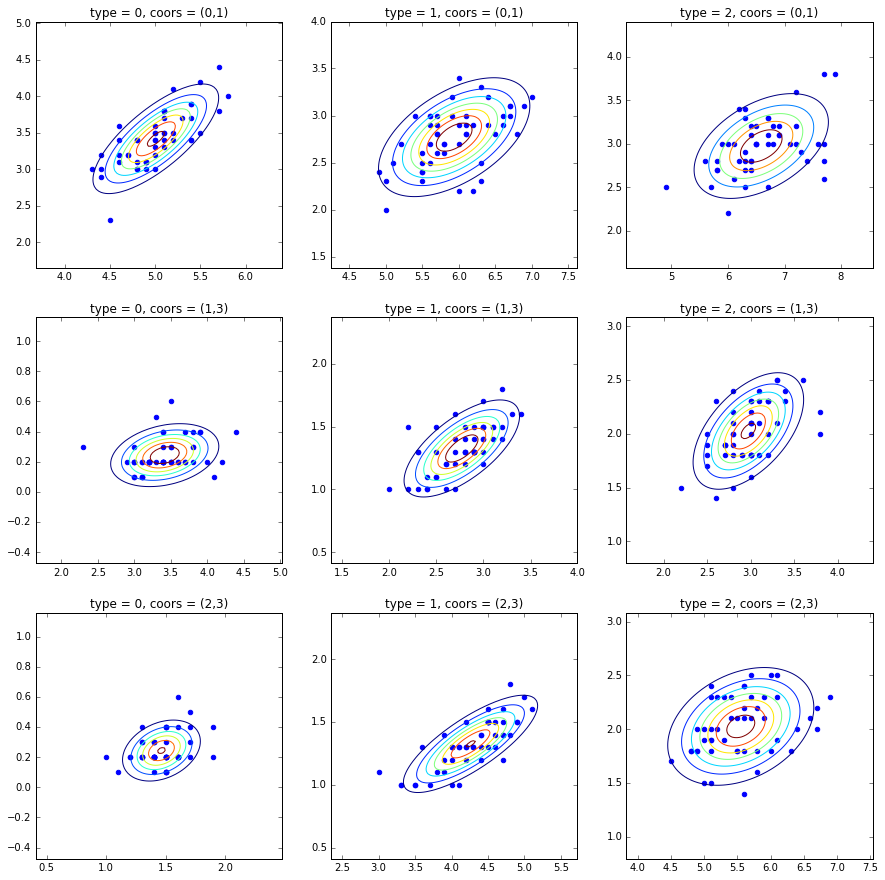

In [4]:
plt.figure(figsize=(15, 15))
for i in range(3):
    for iris_type in [0, 1, 2]:
        build_density([(0, 1), (1, 3), (2, 3)][i], iris_type, iris_type + i*3)
plt.show()

Оценим вероятности P(𝑇 = 𝑘) частотами вхождений 𝑘-ых компонент смеси в данную выборку

In [5]:
print np.array([float(len(iris[i])) for i in (0, 1, 2)]) / len(data.target)

[ 0.33333333  0.33333333  0.33333333]


Все компоненты смеси встречаются равновероятно. Значит, будем считать мат. ожидание и плотности отрицания как среднее между двумя другими. 

Вычислим условное математическое ожидание $E(𝑋 \mid 𝑇 \ne 𝑘)$ для всех 𝑘 = 1, 2, 3 (три 4-мерных вектора). 

In [6]:
exp_est = np.zeros(12).reshape(3, 4)
for i in range(3):
    ar = iris[i]
    exp_est[i] = np.mean(ar, axis=0)
exp_cond = [(exp_est[1] + exp_est[2]) / 2, (exp_est[0] + exp_est[2]) / 2, (exp_est[0] + exp_est[1]) / 2]

for i in range(3):
    print 'E(X|T != ' + str(i) +') = ' + str(exp_cond[i])

E(X|T != 0) = [ 6.262  2.872  4.906  1.676]
E(X|T != 1) = [ 5.797  3.196  3.508  1.135]
E(X|T != 2) = [ 5.471  3.094  2.862  0.785]


Для пар координат (0, 1), (1, 3) и (2, 3) постройм графики условной плотности $p(𝑋 \mid 𝐼\{T \ne 𝑘\})(x \mid 1)$ (9 штук).

In [7]:
def build_cond_density(coors, iris_type):
    #извлекаем нужные координаты
    cur_types = range(3)
    cur_types.remove(iris_type)
    pairs = np.array([[iris[cur_types[0]].transpose()[coors[0]],
                       iris[cur_types[0]].transpose()[coors[1]]],
                      [iris[cur_types[1]].transpose()[coors[0]],
                       iris[cur_types[1]].transpose()[coors[1]]]])

    #ищем (оцениваем) параметры разложения
    a_est = [[pairs[0][0].mean(), pairs[0][1].mean()], 
             [pairs[1][0].mean(), pairs[1][1].mean()]]
    sigma_est = np.zeros(8).reshape(2, 2, 2)
    for i in range(2):
        for j in range(2):
            sigma_est[0][i][j] = np.mean(pairs[0][i] * pairs[0][j]) - np.mean(pairs[0][i]) * np.mean(pairs[0][j])
            sigma_est[1][i][j] = np.mean(pairs[1][i] * pairs[1][j]) - np.mean(pairs[1][i]) * np.mean(pairs[1][j])

    #считаем плотность
    grid = np.mgrid[left:right:0.05, left:right:0.05]
    size = grid[0].shape[0]
    density = np.zeros(size**2).reshape(size, size)
    for i in range(size):
        for j in range(size):
            density[i][j] = (sps.multivariate_normal.pdf((grid[0, i, j], grid[1, i, j]), mean=a_est[0], cov=sigma_est[0]) + \
                             sps.multivariate_normal.pdf((grid[0, i, j], grid[1, i, j]), mean=a_est[1], cov=sigma_est[1])) \
                             / 2.
    
    #строим график
    plt.figure(figsize=(7, 7))
    plt.contour(grid[0], grid[1], density)  # нарисовать указанные линии уровня
    plt.title('type = ' + str(iris_type) + ', coors = (' + str(coors[0]) + ',' + str(coors[1]) + ')')
    plt.show()

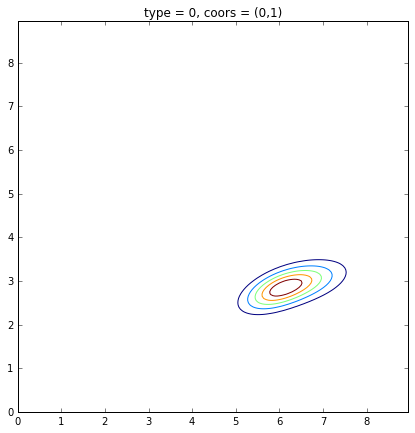

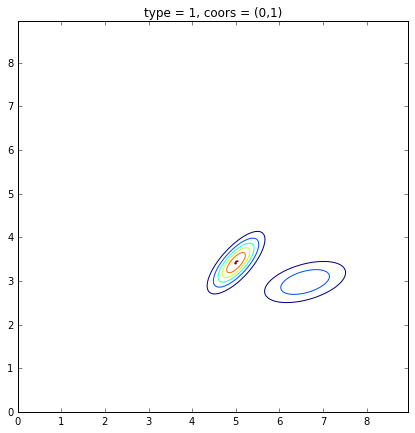

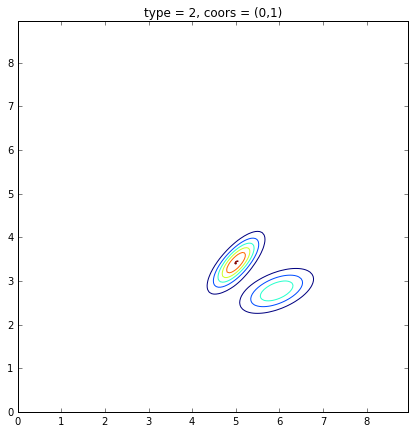

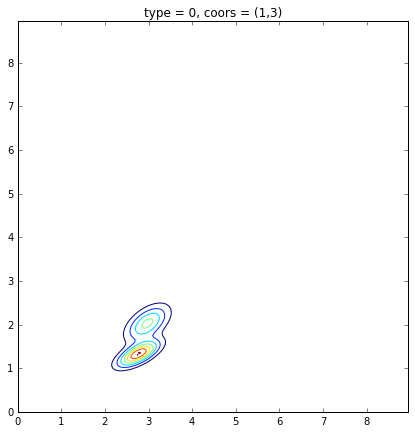

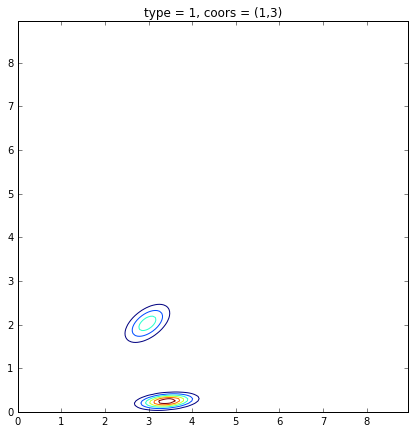

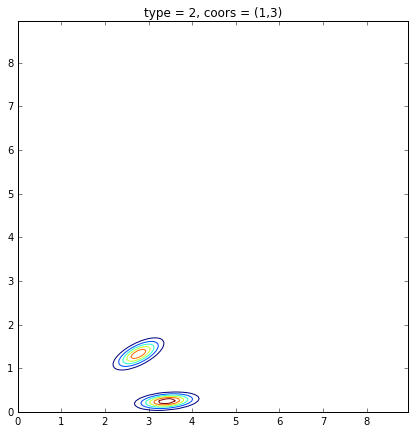

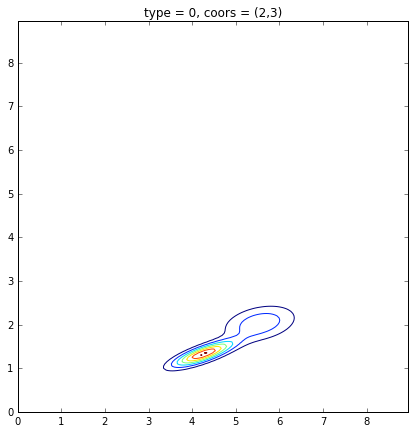

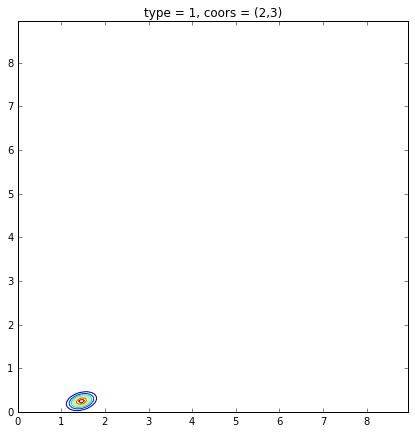

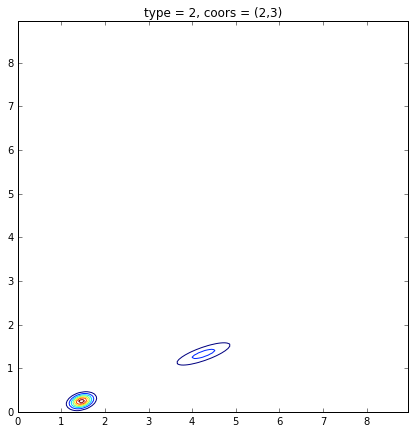

In [8]:
for coors in [(0, 1), (1, 3), (2, 3)]:
    for iris_type in [0, 1, 2]:
        build_cond_density(coors, iris_type)

Классифицируем все пространство 4-мерных векторов по принципу $𝑘 = \underset{k}{\operatorname{argmax}} p(𝑋 \mid 𝐼\{𝑇 = 𝑘\})(x \mid 1)$ (здесь условная плотность считается на основе оценок для 4-мерных векторов).

In [9]:
#ищем оценки параметров распределения для каждого типа

a_ests = np.zeros(3*4).reshape(3, 4) # тип, оценка мат ожидания
sigma_ests = np.zeros(3*4*4).reshape(3, 4, 4) # тип, оценка матрицы ковариаций
for iris_type in [0, 1, 2]:    
    #ищем (оцениваем) параметры разложения
    cur_iris_ar = iris[iris_type].transpose()
    a_est = cur_iris_ar.mean(axis=1)
    sigma_est = np.zeros(4*4).reshape(4, 4)
    for i in range(4):
        for j in range(4):
            sigma_est[i][j] = np.mean(cur_iris_ar[i] * cur_iris_ar[j]) - \
                              np.mean(cur_iris_ar[i]) * np.mean(cur_iris_ar[j])

    a_ests[iris_type] = a_est
    sigma_ests[iris_type] = sigma_est
    
#функция предсказания типа точки
def iris_pred_type(point):
    p = [0., 0., 0.]
    for iris_type in [0, 1, 2]:
        mean = a_ests[iris_type]
        cov = sigma_ests[iris_type]
        p[iris_type] = sps.multivariate_normal.pdf(point, mean=mean, cov=cov)
    return p.index(max(p))

Посчитаем долю ошибок на выборке

In [10]:
mistakes_cnt = 0
for iris_type in [0, 1, 2]:
    for point in iris[iris_type]:
        prediction = iris_pred_type(point)
        if prediction != iris_type:
            mistakes_cnt += 1
print 'Доля ошибок = ' + str(mistakes_cnt / float(len(data.target)))

Доля ошибок = 0.02


Нарисуем классификацию всего пространства в проекции на пары координат (0, 1), (1, 3) и (2, 3), где закрасим разными цветами области, которые образовались в результате классификации.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


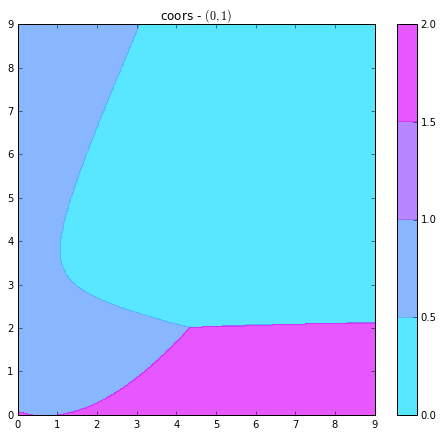

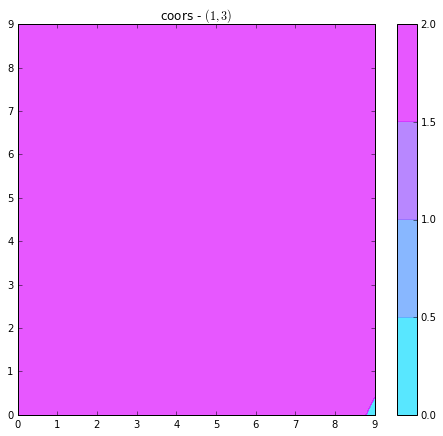

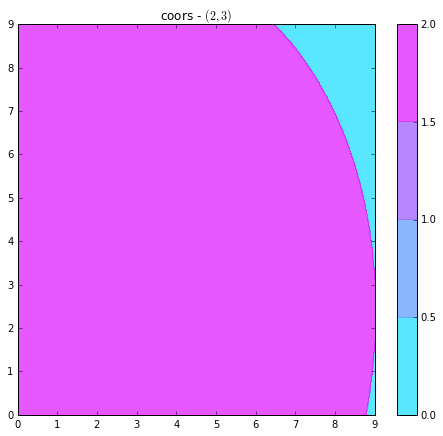

In [11]:
for coors in [(0, 1), (1, 3), (2, 3)]:
    #получаем сетку для построения
    grid_x = np.linspace(left,right,500)
    grid_y = np.linspace(left,right,500)
    x_for_plot, y_for_plot = np.meshgrid(grid_x, grid_y)
    
    #считаем тип для каждой точки
    pred_type_ar = np.arange(500*500).reshape(500,500)
    for i in range(len(grid_x)):
        for j in range(len(grid_y)):
            point = [0, 0, 0, 0]
            point[coors[0]] = grid_x[i]
            point[coors[1]] = grid_y[j]
            pred_type_ar[i][j] = iris_pred_type(point)
            
    #строим график
    plt.figure(figsize=(8, 7))        
    CS = plt.contourf(x_for_plot, y_for_plot, pred_type_ar, 3, alpha=.75, cmap='cool')
    plt.colorbar(CS, shrink=1)
    plt.title(r'coors - $' + str(coors) + '$')
    plt.legend()
    plt.show()